# LoopGAN — Loop generation with StyleGAN2 and MelGAN

In [1]:
import argparse
import torch
from torchvision import utils
from model_drum import Generator
import sys
sys.path.append('./melgan')
from modules import Generator_melgan
import os, random
import librosa, librosa.display
import soundfile as sf
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import IPython.display as ipd

c:\Users\nao\anaconda3\envs\aidj3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download a pre-trained model in advance

``` 
$ gdown -O drumbeats1_230000.pt 1B3ZWTJFuZbPPH4uIIz-pCcBTLu9-w4nw
```

In [2]:

# Constants - do not change! 
N_LATENT = 512
N_MLP = 8
SIZE_OUTPUT = 64 # size of output image
TRUNCATION = 1 # if this is >=1, then no truncation
TRUNCATION_MEAN = 4096 # # of samples for getting mean latent
SR = 44100

# Number of samples (loops) in a batch
n_samples = 4  # batch size

# name of pre-trained StyleGAN2 model
CHECKPOINT = "./drumbeats1_230000.pt" 

# mean / std of Spectrograms of training data. used for the conversion from generated spectrograms into wav files
DATAPATH = "./data/drumbeats_1bar/" 

# name of pre-trained MelGAN model
MELGAN_MODEL_NAME = "best_netG.pt"

# GANSpace - # of PCA components
N_PCA_COMPS = 6

# Use "cuda" if you have GPUs on your machine
device_name = "cuda"


### Load models

In [3]:
# Load a StyleGAN2 model
generator = Generator(SIZE_OUTPUT, N_LATENT, N_MLP, channel_multiplier=2).to(device_name)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(device_name))

generator.load_state_dict(checkpoint["g_ema"], strict=False)

if TRUNCATION < 1:
    with torch.no_grad():
        mean_latent = generator.mean_latent(TRUNCATION_MEAN)
else:
    mean_latent = None

In [4]:
# Load a MelGAN model
def load_vocoder(device_name):
    feat_dim = 80
    mean_fp = f'{DATAPATH}/mean.mel.npy'
    std_fp = f'{DATAPATH}/std.mel.npy'
    v_mean = torch.from_numpy(np.load(mean_fp)).float().view(1, feat_dim, 1).to(device_name)
    v_std = torch.from_numpy(np.load(std_fp)).float().view(1, feat_dim, 1).to(device_name)
    
    vocoder_config_fp = './melgan/args.yml'
    vocoder_config = read_yaml(vocoder_config_fp)

    n_mel_channels = vocoder_config.n_mel_channels
    ngf = vocoder_config.ngf
    n_residual_layers = vocoder_config.n_residual_layers

    vocoder = Generator_melgan(n_mel_channels, ngf, n_residual_layers).to(device_name)
    vocoder.eval()

    vocoder_param_fp = os.path.join('./melgan', MELGAN_MODEL_NAME)
    vocoder.load_state_dict(torch.load(vocoder_param_fp, map_location=torch.device(device_name)), strict=False)

    return vocoder, v_mean, v_std

VOCODER, V_MEAN, V_STD = load_vocoder(device_name)

def vocode(sample, vocoder=VOCODER, v_mean=V_MEAN, v_std=V_STD):
    de_norm = sample.squeeze(0) * v_std + v_mean
    audio_output = vocoder(de_norm)
    return audio_output

# GANSpace 
Härkönen, Erik, Aaron Hertzmann, Jaakko Lehtinen, and Sylvain Paris. 2020. “GANSpace: Discovering Interpretable GAN Controls.” arXiv [cs.CV]. arXiv. http://arxiv.org/abs/2004.02546.

Explained Variance:  [0.13546072 0.09420928 0.07633555 0.03415269 0.02210107 0.02025821]


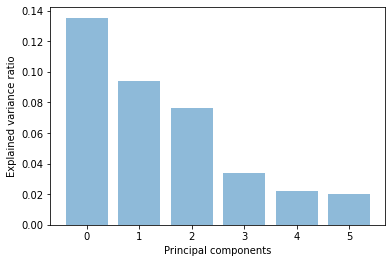

In [5]:
from sklearn.decomposition import PCA

# Generate random W (style vectors) with random Z 
randz = torch.randn(2000, N_LATENT, device=device_name) 
randw = generator.get_latent(randz).detach().cpu().numpy()

# Find principal components using PCA 
pca = PCA(n_components=N_PCA_COMPS)
pca.fit(randw)
pcomponents = torch.tensor(pca.components_) # PCA components

# Explained variance
explained_variance = pca.explained_variance_ratio_
print('Explained Variance: ', explained_variance)

# Scree plot
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

# probably 6 components are enough

### Generation

To make it easier to handle on Max/MSP, generated loops is saved as a wav file with `n_samples` channels. (default: 4ch)

In [6]:
from pydub import AudioSegment

prev_w = None

# Adde PCAed W vector
def get_w(w, coefs, scale=1.0):
    coefs = coefs[:N_PCA_COMPS]
    w_diff = pcomponents * torch.tensor([coefs]).T
    w_diff = w_diff.to(device_name)
 
    # add each PCA component vector
    for i in range(w.shape[0]): # batch
        for j in range(w_diff.shape[0]):
            w[i] += w_diff[j]       
    return w

# main function
# g_ema: stylegan generator
# center_z: to specify the input latent z 
# trucation: GAN trucation value
# variation: the scale of noise added to center_z (= vatiation in a batch)
def generate(g_ema=generator, center_z=None, use_prev_w = False, truncation=TRUNCATION, variation=0.10, coef=None):
    global prev_w

    print("generating...")

    with torch.no_grad():
        g_ema.eval()
        
        if not use_prev_w or prev_w == None:
            if center_z is None:
                # random init
                sample_z = torch.randn(1, N_LATENT, device=device_name)
                sample_z = sample_z.repeat(n_samples, 1) +  torch.randn(n_samples, N_LATENT, device=device_name) * variation
            else:
                # use specific latent z
                sample_z = center_z + torch.randn(n_samples, N_LATENT, device=device_name) * variation
            sample_z = sample_z.float()
            
            # Generate!!!            
            sample_w = g_ema.get_latent(sample_z)
        else:
            sample_w = prev_w

        # store for the next round
        prev_w = sample_w.detach().clone()

        if coef and use_prev_w:
            sample_w = get_w(sample_w, coef)
                    
        sample_w = sample_w.unsqueeze(1).repeat(1, N_LATENT, 1)    
        sample, _ = g_ema([sample_w], truncation=truncation, truncation_latent=mean_latent, input_is_latent=True)

        # Saving tje generated spectrogram image
        randid = random.randint(0, 10000)
        imagepath = f'/tmp/img_{randid}.png'
        utils.save_image(sample, imagepath, nrow=1, normalize=True, range=(-1, 1))

        # sample_spec = (sample * V_STD + V_MEAN).squeeze().detach().cpu().numpy()
        # librosa.display.specshow(sample_spec[0], sr=44100, hop_length=257, n_fft=1024)

        # Saving multi channel audio file
        filepath = f'/tmp/gem_{randid}.wav'
        channels = [] 
        numpy_chs = []  # for numpy array
        # convert (n_samples) spectrogram into audio, one by one 
        for i in range(n_samples):
            audio_output = vocode(sample[i])
            audio_output = audio_output.squeeze().detach().cpu().numpy() 
            numpy_chs.append(audio_output)
  
            channel = AudioSegment( (audio_output*np.iinfo(np.int16).max).astype("int16").tobytes(), sample_width=2, # 16 bit 
                    frame_rate=SR, channels=1)
            channels.append(channel)
        # save as a wav file with (n_samples) channel
        multich = AudioSegment.from_mono_audiosegments(*channels)
        multich.export(filepath, format="wav")
        
        return filepath, imagepath, np.array(numpy_chs)


### Test

Let's generate random loops with random input latent z

generating...


c:\Users\nao\anaconda3\envs\aidj3\lib\site-packages\torchvision\utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


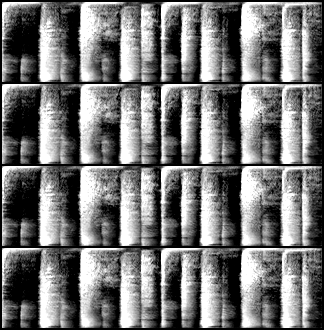

In [7]:
# random generation 
_,  imagepath, audio_output = generate(variation=0.0)

# display the generated spectrogram
ipd.display(ipd.Image(filename=imagepath))


# play the first channel
ipd.display(ipd.Audio(audio_output[0], rate=SR))

# GANSpace test
interpolation of the first PCA components

In [18]:
# baseline
print("baseline rhythm")
_,  imagepath, audio_output = generate(variation=0.0)
ipd.display(ipd.Audio(audio_output[0], rate=SR))
print("------------")
print("\n")

# changing the 1st component
print("changing the 1st PCA component")
for x in np.linspace(-10, 10, 7):
    _, _, audio_output  = generate(center_z=None, use_prev_w=True, coef = [x,0,0,0,0,0]) 
    print("1st component:", x)
    ipd.display(ipd.Audio(audio_output[0], rate=SR))

baseline rhythm
generating...


------------


changing the 1st PCA component
generating...
1st component: -10.0


generating...
1st component: -6.666666666666666


generating...
1st component: -3.333333333333333


generating...
1st component: 0.0


generating...
1st component: 3.333333333333334


generating...
1st component: 6.666666666666668


generating...
1st component: 10.0


#### Stereo effect
Small gausian noise can be added to the input latent vector z. If you play the first and second sample in the generated batch as a stereo audio file, then you'll get an interesting stereo effect. Try different numbers! 

generating...


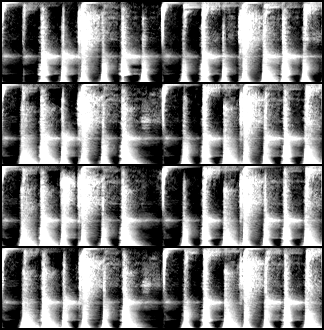

In [19]:
_,  imagepath, audio_output = generate(variation=0.35)

ipd.display(ipd.Audio(audio_output[:2], rate=SR)) # stereo 

ipd.display(ipd.Image(filename=imagepath))


### OSC server/client for Max/MSP

In [20]:
from pythonosc import dispatcher
from pythonosc import osc_server, udp_client
import os, random

# client
client = udp_client.SimpleUDPClient('127.0.0.1', 10018)

# generate randomly
def generate_random(unused_addr, x1,x2,x3,x4,x5,x6, variation=0.1):
    audiopath, imagepath, _ = generate(center_z=None, use_prev_w=False, variation=variation, coef = [x1,x2,x3,x4,x5,x6]) # random sample
    client.send_message("/generated", (audiopath, imagepath)) # init both R and L
    
# morphing
def generate_xy(unused_addr, x1,x2,x3,x4,x5,x6, variation=0.0):
    audiopath, imagepath, _  = generate(center_z=None, use_prev_w=True, variation=variation, coef = [x1,x2,x3,x4,x5,x6]) # random sample
    client.send_message("/generated", (audiopath, imagepath))

# server
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/generate_random", generate_random)
dispatcher.map("/generate_xy", generate_xy)

server = osc_server.ThreadingOSCUDPServer(
    ('localhost', 10015), dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()




Serving on ('127.0.0.1', 10015)
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
generating...
ge